# Analysing sets of bell inequalities 
This notebook should analyse bell inequalities that are found for the finite efficiency PR box. The bell inequalities
considered here should equalize at the threshold efficiency of the PR box. But there also might be some inequalities, that are just positivity constraints. Thus we have to filter out, which inequalities fulfill all conditions for the PR box.

We want to find out if there is a structure behind these bell inequalities for different cases.

First we load the Bell inequalities from the files generated by the remote computer.

In [29]:
import numpy as np
from linearbell.utils import get_configs, get_deterministic_behaviors, check_equiv_bell_vertex_enum

ma = 3
mb = 3
n = 3

file = '../data/pr_box_finite_efficiency_bell_lifted_partial/{}{}{}{}.txt'.format(ma,mb,n-1,n-1)
all_inequalities = np.loadtxt(file)

# get configs and deterministic behaviors
configs = get_configs(range(ma), range(mb), range(n), range(n))
dets = get_deterministic_behaviors(range(ma), range(mb), range(n))

For later testing define the pr boxes. Here we don't need to shift the origin, as we're not using vertex enumeration
to find these Bell inequalities, but just linear programming.

In [30]:
from linearbell.utils import general_pr_box_extended
eta = 4 / (4 + ma)
pr_box= [general_pr_box_extended(a, b, x, y, eta, range(2)) for (a, b, x, y) in configs]

epsilon = 0.05
pr_box_high = [general_pr_box_extended(a, b, x, y, eta + epsilon, range(2)) for (a, b, x, y) in configs]
pr_box_low= [general_pr_box_extended(a, b, x, y, eta - epsilon, range(2)) for (a, b, x, y) in configs]


As we have loaded all bell inequalities, we have to check how many bell inequalities are of the same class and if actually
all bell inequalities fulfill the conditions we have.
**Note that the Conditions here are inverted to the Vertex enumeration condition. Linear Programming uses the other way
around. So local boxes have bell value higher than 1 and non local below 1**.


In [31]:
correct_inequalities = []
for b in all_inequalities:
    try:
        assert np.abs(pr_box @ b - 1) < 1e-4, 'Threshold eff PR box is not equalizing: {}'.format(pr_box @ b)
        assert b @ pr_box_high < 1.0, 'High efficiency Pr Box does not violate: PR * b = {}'.format(pr_box_high @ b)
        assert b @ pr_box_low > 1.0, 'Low efficiency PR box is not local: PR * b = {}'.format(pr_box_low @ b)

        correct_inequalities.append(b)
    except AssertionError as e:
        print(e)
correct_inequalities = np.array(correct_inequalities)
print('Number of bell inequalities: {}'.format(correct_inequalities.shape[0]))

Number of bell inequalities: 8


Check how many classes of bell inequalities there are.

In [32]:
from linearbell.utils import affine_transform_bell, get_allowed_relabellings
relabels = get_allowed_relabellings(range(ma), range(mb), range(n), range(n))
print('Got all the relabellings')
# shift the inequalities
correct_inequalities = affine_transform_bell(correct_inequalities, dets)

# find the number of classes
del_ineq = []
for i in range(correct_inequalities.shape[0]):
    print('facet: {} / {} || len deletion list: {}'.format(i, correct_inequalities.shape[0], len(del_ineq)))
    # if this facet can already be deleted -> continue
    if i in del_ineq: continue
    for j in range(i + 1, correct_inequalities.shape[0]):
        # if this facet can already be deleted -> continue
        if j in del_ineq: continue
        # check if the two facets are equivalent
        if check_equiv_bell_vertex_enum(correct_inequalities[i], correct_inequalities[j], relabels, dets, tol=1e-4):
            del_ineq.append(j)
# store new facets
classes_inequalities = np.delete(correct_inequalities, del_ineq, axis=0)
print('Classes of inequalities: {}'.format(classes_inequalities.shape[0]))

Got all the relabellings
facet: 0 / 8 || len deletion list: 0
facet: 1 / 8 || len deletion list: 7
facet: 2 / 8 || len deletion list: 7
facet: 3 / 8 || len deletion list: 7
facet: 4 / 8 || len deletion list: 7
facet: 5 / 8 || len deletion list: 7
facet: 6 / 8 || len deletion list: 7
facet: 7 / 8 || len deletion list: 7
Classes of inequalities: 1


As we can see not all of the bell inequalities we find are actually bell inequalities. Maybe we also have
to do a check for facets.

We have now the bell inequalities and want to display them in matrix form. Currently they are just in vector
form and the configuration of inputs / outputs at each entry is stored in the corresponding *configXXXX* variable.
Therefore define a function that returns the configurations in matrix form and a function that transforms vector form
bell inequalities to matrix form.

Now use these functions to reshape the vectors of bell inequalities

In [37]:
from linearbell.representations import get_configs_mat, transform_vec_to_mat
configs_mat = get_configs_mat(range(ma), range(mb), range(n), range(n))

mat_inequalities = []
for b in all_inequalities:
    m = transform_vec_to_mat(configs, configs_mat, b)
    mat_inequalities.append(m)
mat_inequalities = np.array(mat_inequalities)

No we can display the matrix with matplotlib.

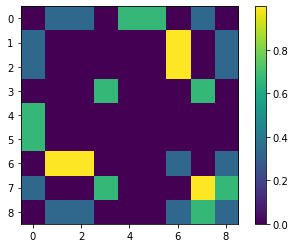

In [42]:
mat = mat_inequalities[7]

import matplotlib.pyplot as plt
hm = plt.imshow(mat)
plt.colorbar(hm)
plt.show()

Test if the result that Tom found is equivalent to my result.

In [48]:
from linearbell.representations import transform_mat_to_vec

# define toms result
check_mat = [[0, 1/3, 0, 0, 1/3, 0, 0, 2/3 , 0],
             [1/3, 0, 1/3, 1/3, 0, 1/3, 2/3, 0,0],
             [0, 1/3, 0, 0, 1/3, 0, 0, 2/3, 0],
             [0, 1/3, 0, 1/3, 0, 1/3, 0, 0, 0],
             [1/3, 0, 1/3, 0, 1/3, 0, 2/3, 0, 0],
             [0, 1/3, 0, 1/3, 0, 1/3, 0, 0, 0],
             [0, 2/3, 0, 0, 2/3, 0, 2/3, 0, 2/3],
             [2/3, 0, 2/3, 0, 0, 0, 0, 2/3, 2/3],
             [0, 0, 0, 0, 0, 0, 2/3, 2/3, 2/3]]
check_mat = np.array(check_mat)
check_vec = transform_mat_to_vec(configs_mat, configs, check_mat)
check_vec = affine_transform_bell([check_vec], dets)[0]
res = check_equiv_bell_vertex_enum(check_vec, classes_inequalities[0], relabels, dets, tol=1e-4)
if res:
    print('YUUHUU, its an equivalent expression')

YUUHUU, its an equivalent expression
